---
authors:
  - name: "Max Jones"
    affiliations:
      - "Development Seed"
    email: "max@developmentseed.org"
    orcid: "0000-0003-0180-8928"
    github: "maxrjones"
---

# ☁️ 4 - Data in the Cloud 101

:::{tip} 🧭 Where we are going
:icon: false

By the end of this module, you will be able to:

- Explain the key benefits and pitfalls of working with data on the Cloud
- Open cloud hosted data in a performant way
- Scale your analyses using Dask or Cubed
- Find communities to learn more about cloud native science
:::


## Introduction

This notebook is for the workshop ([Open Source Geospatial Workflows in the Cloud](https://geojupyter.github.io/workshop-open-source-geospatial)) presented at the [AGU Fall Meeting 2025](https://agu.confex.com/agu/agu25/meetingapp.cgi/Session/252640).

## What is the cloud?

The cloud (as defined by [cloudfare](https://www.cloudflare.com/)) is a distributed collection of servers that host software and infrastructure, and it is accessed over the Internet. The map below (from [salesforce](https://trailhead.salesforce.com/content/learn/modules/aws-cloud-technical-professionals/explore-the-aws-global-infrastructure-technical-professionals)) shows [Amazon Web Service (AWS)](https://aws.amazon.com)'s global distribution of data centers, which contain the resources that make up the AWS cloud. The three largest cloud providers in the United States are [AWS](https://aws.amazon.com/), [Google Cloud Platform](https://cloud.google.com/), and [Microsoft Azure](https://azure.microsoft.com/en-us), but other cloud providers are larger elsewhere in the world and there are numerous smaller providers available.

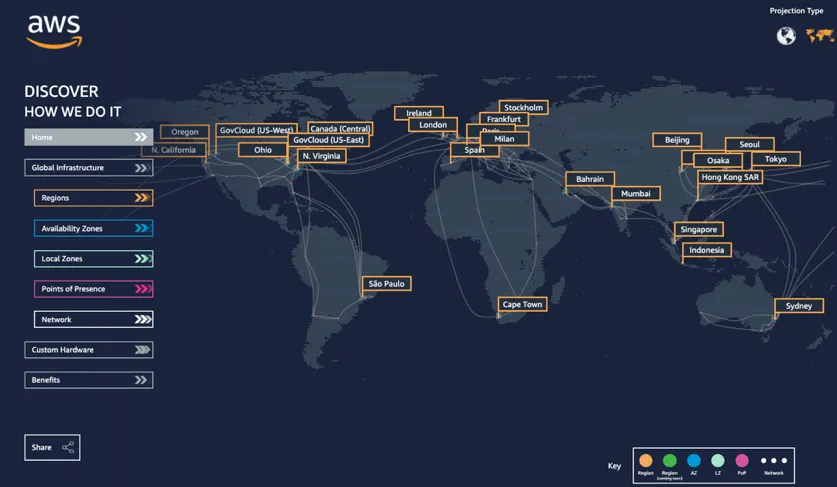

## What makes data on the cloud different?

Hosting data on the cloud differs from storing data locally (or on-premises) in a few important ways:

- Redundancy - you can easily replicate your data across multiple servers, which may be distributed across the globe
- Reliability - cloud providers offer services for reliability, such as automated backups and recovery
- Scalability - you can easily increase or decrease your data storage access, without needing to order or decommission servers or hard-drives
- Accessibility - anyone in the world, with proper authorization, can access data shared on the cloud in a rapid amount of time

There are a couple implications that you should be aware of when working with data on the cloud:

- Pay-as-you-go - Most cloud providers use pay-as-you-go pricing, where you only pay for the storage and services that you use. This can potentially reduce costs, especially upfront costs (e.g., you never need to buy a hard drive). However, it can be easy to forget about data in storage and continue to pay for it indefinitely.
- Time and cost of bringing data to your computer - Hosting the data on the cloud naturally means it's no longer already near your computer's processing resources. Transporting data from the cloud to your computer is expensive, since most cloud providers charge for any data leaving their network, and slow, since the data needs to travel large distances. The primary solution for this is "data-proximate computing" which involves running your code on computing resources in the same cloud location as your data. In with "data-proximate computing", there are many other ways to make working with data on the cloud cheaper and easier. Let's take a look!

## What is cloud-native data?

Cloud native data are structured for efficient querying across the network. You can learn more about these data in the [CNG data formats guide](https://guide.cloudnativegeo.org/), but here we'll just explore working with data that is, compared to data that isn't, optimized for cloud usage.

### Opening archival data with fsspec + netcdf4

First import the necessary libraries

In [ ]:
import fsspec
import xarray as xr

List the files available following this pattern on AWS S3 storage

In [ ]:
fs = fsspec.filesystem('s3', anon=True)
oisst_files = fs.glob('s3://noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/202408/oisst-avhrr-v02r01.*.nc')
oisst_files = sorted(['s3://'+f for f in oisst_files])

Open a file without any configuration and find the maximum value.

In [ ]:
%%time
with fs.open(oisst_files[0]) as file:
    ds = xr.open_dataset(file, engine="h5netcdf")
    print(ds['sst'].max())

This took a lot of time to open the file. Let's look how we can speed that up by configuring the caching strategy:

In [ ]:
%%time
fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}
with fs.open(oisst_files[0]) as file:
    ds = xr.open_dataset(file, engine="h5netcdf")
    print(ds['sst'].max())

### Opening archival data with obstore + netcdf4

Obstore is another library for interacting with cloud data. It's more verbose than fsspec because explicit usage patterns are core to its design patterns. You may want to use obstore if performance matters a lot to you, since it's very fast.

In [ ]:
from obspec_utils import ObstoreReader, ObstoreMemCacheReader
from obstore.store import S3Store
import obstore as obs
from urllib.parse import urlparse

List the files available following at this prefix on AWS S3 storage. Currently there's no globbing functionality but that will be added in the future to obspec_utils.

In [ ]:
bucket = "noaa-cdr-sea-surface-temp-optimum-interpolation-pds"
path = "data/v2.1/avhrr/202408/"
store = S3Store(bucket=bucket, region="us-east-1", skip_signature=True)
list_stream = obs.list_with_delimiter(store, prefix=path)
paths = [x["path"] for x in list_stream["objects"]]

Open a file without any configuration and find the maximum value.

In [ ]:
%%time
reader = ObstoreReader(store=store, path=paths[0])
with xr.open_dataset(reader, engine="h5netcdf") as ds:
    print(ds['sst'].max())

We can instead cache the entire file in memory, if we know that we'll need to read most of file (as is needed for finding the mean of a variable).

In [ ]:
%%time
reader = ObstoreMemCacheReader(store=store, path=paths[0])
with xr.open_dataset(reader, engine="h5netcdf") as ds:
    print(ds['sst'].max())

### Opening archival data using VirtualiZarr + Icechunk

### Opening cloud native data (Zarr)

### Scaling computations with Dask

### Scaling computations with Cubed

## References

- [Cloud-Optimized Geospatial Formats Guide](https://guide.cloudnativegeo.org/)
- [Xarray Tutorial - Zarr in Cloud Object Storage](https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html)
- [Xarray Tutorial - Access Patterns to Remote Data with fsspec](https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html)